## Installing and importing the necessary libraries

Firstly, we import and install all the libraries which will be used in the notebook

In [1]:
!pip install gdown

In [2]:
!pip install tensorflow==2.14.0

  Obtaining dependency information for tensorflow==2.14.0 from https://files.pythonhosted.org/packages/e2/7a/c7762c698fb1ac41a7e3afee51dc72aa3ec74ae8d2f57ce19a9cded3a4af/tensorflow-2.14.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for ml-dtypes==0.2.0 from https://files.pythonhosted.org/packages/d1/1d/d5cf76e5e40f69dbd273036e3172ae4a614577cb141673427b80cac948df/ml_dtypes-0.2.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 2.8 MB/s eta 0:00:00
  Obtaining dependency information for tensorboard<2.15,>=2.14 from https://files.pythonhosted.org/packages/73/a2/66ed644f6ed1562e0285fcd959af17670ea313c8f331c46f79ee77187eb9/tensorboard-2.14.1-py3-none-any.whl.metadata
  Obtaining dependency information for tensorflow-estimator<2.15,>=2.14.0 from https://files.pythonhosted.org/packages/d1/da/4f264c196325bb6e37a6285caec5b12a03def489b57cc1fdac02bb6272cd/tensor

In [3]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [4]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


In [5]:
!pip install scipy==1.7.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 25.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 61.2 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.3
    Uninstalling numpy-1.24.3:
      Successfully uninstalled numpy-1.24.3
  Attempting uninstall: scipy
    Found existing installation: SciPy 1.11.4
    Uninstalling SciPy-1.11.4:
      Successfully uninstalled SciPy-1.11.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cuml 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.7 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10

In [6]:
import warnings
warnings.filterwarnings("ignore")

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
import gdown
import numpy as np
import pandas as pd

### Load and process data

We get our data from a folder via gdown.

In [8]:
# Function to download and load a .npy file
def download_and_load_npy(url):
    output_file = gdown.download(url, quiet=True)
    return np.load(output_file)

In [9]:
# Google Drive URLs for the .npy files
categories_url = "https://drive.google.com/uc?id=1UiZliu_AQdlkjRhVf61Cc0_iJNvIbSyJ"
training_dataset_url = "https://drive.google.com/uc?id=1hIkzsOiDMX5B7pwxyJkiOEBV1nW6_cOB"
validation_periods_url = "https://drive.google.com/uc?id=1nV6ugTmqf--NTzBZCpb80PO0YZmsjigs"

In [10]:
categories = download_and_load_npy(categories_url)
training_dataset = download_and_load_npy(training_dataset_url)
validation_periods= download_and_load_npy(validation_periods_url)

In [11]:
cdf = pd.DataFrame(categories)
tdf = pd.DataFrame(training_dataset)
vdf = pd.DataFrame(validation_periods)

In [12]:
# Rename the columns of our vdf dataframe to Start (the time instance at which the time series starts) and End (time at which it ends)
vdf = vdf.rename(columns={0: "Start", 1: "End"})

In [13]:
# we define an interval column for our df which contains the timeframe in which the time series are occurring
# the column represents the length of the time series
vdf["Interval"] = vdf["End"] - vdf["Start"]

### Plotting functions

We define a number of plotting functions that will be used throughout the notebook.

In [14]:
def plot_series(series):
    plt.figure(figsize=(12, 6))
    plt.plot(series, label='Time Series')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

In [15]:
def plot_epochs(history):
    best_epoch = np.argmin(history['val_loss'])
    plt.figure(figsize=(17,4))
    plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
    plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
    plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
    plt.title('Mean Squared Error')
    plt.legend()
    plt.grid(alpha=.3)
    plt.show()

    plt.figure(figsize=(18,3))
    plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
    plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
    plt.legend()
    plt.grid(alpha=.3)
    plt.show()

In [16]:
def plot_graphs(df, n):
    # Number of time series to plot
    plt.figure(figsize=(15, 8))
    for i in range(n):
        plt.plot(df.loc[df.index[i], :], label=f'Series {F.index[i]}')
    plt.title(f'Plot of {n} Representative Time Series')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

### Handling missing Data

We turn the zeroes outside of the intervals in which the time series are valid to nan values.

In [17]:
for i in range(0, tdf.shape[0]):
    start = vdf.iloc[i, 0]
    end = vdf.iloc[i, 1]
    tdf.iloc[i, :start] = np.nan
    tdf.iloc[i, end:] = np.nan

#### Selecting the appropriate Time Series for Training

We now select the rows of all time series belonging to the different categories and create 3 new DataFrames containing only the rows in which we're interested, which will be used to build our 3 models.

In [18]:
tdf['category'] = cdf.iloc[:, 0]
categories = tdf.iloc[:, -1].unique()

In [19]:
data_by_category = {category: tdf.loc[tdf.iloc[:, -1] == category,:].iloc[:,:-1]
                    for category in categories}

In [20]:
A = data_by_category['A']
B = data_by_category["B"]
C = data_by_category["C"]
D = data_by_category["D"]
E = data_by_category["E"]
F = data_by_category["F"]

## Data Exploration

In [21]:
from pandas.plotting import lag_plot
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
import seaborn as sns

We firstly plot the distribution of values by category.

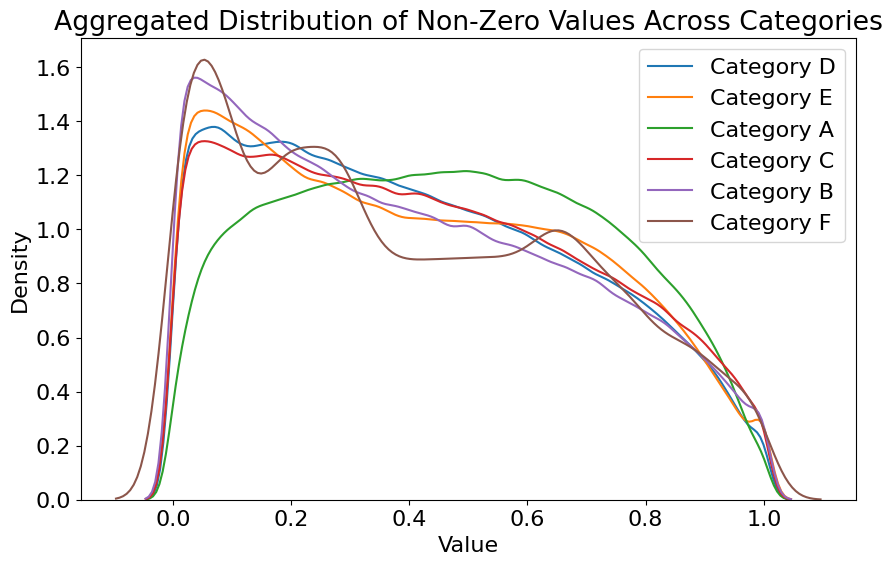

In [22]:
# Create a figure for the overlayed plots
plt.figure(figsize=(10, 6))

for category, df_category in data_by_category.items():
    df = df_category.iloc[:, :-1]

    combined_values = pd.Series(df.values.ravel()).dropna()

    sns.kdeplot(combined_values, label=f'Category {category}')

plt.title('Aggregated Distribution of Non-Zero Values Across Categories')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()

After analyzing the aggregated distribution of the values across different categories, we noticed a shared distribution among categories B, C, D and E, which we then decided to group together.

In [23]:
for i in range(0, cdf.shape[0]):
    if cdf.iloc[i][0] == "B":
        cdf.iloc[i][0] = "BCDE"
    if cdf.iloc[i][0] == "C":
        cdf.iloc[i][0] = "BCDE"
    if cdf.iloc[i][0] == "D":
        cdf.iloc[i][0] = "BCDE"
    if cdf.iloc[i][0] == "E":
        cdf.iloc[i][0] = "BCDE"

In [26]:
tdf['category'] = cdf.iloc[:, 0]
categories = tdf.iloc[:, -1].unique()

In [27]:
data_by_category = {category: tdf.loc[tdf.iloc[:, -1] == category,:].iloc[:,:-1]
                    for category in categories}

In [28]:
A = data_by_category['A']
BCDE = data_by_category['BCDE']
F = data_by_category["F"]

In [29]:
vdf_A = vdf[vdf.index.isin(A.index)]
vdf_BCDE = vdf[vdf.index.isin(BCDE.index)]
vdf_F = vdf[vdf.index.isin(F.index)]

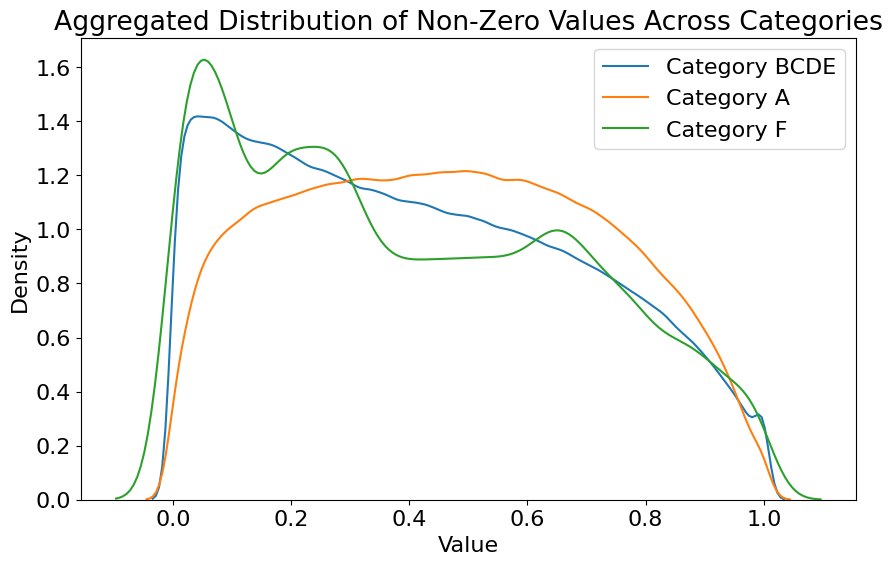

In [30]:
# Create a figure for the overlayed plots
plt.figure(figsize=(10, 6))

for category, df_category in data_by_category.items():
    df = df_category.iloc[:, :-1]

    combined_values = pd.Series(df.values.ravel()).dropna()

    sns.kdeplot(combined_values, label=f'Category {category}')

# Finalize and show the overlayed density plots
plt.title('Aggregated Distribution of Non-Zero Values Across Categories')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()

We now plot the distribution of missing data for all time series belonging to the 3 groups.

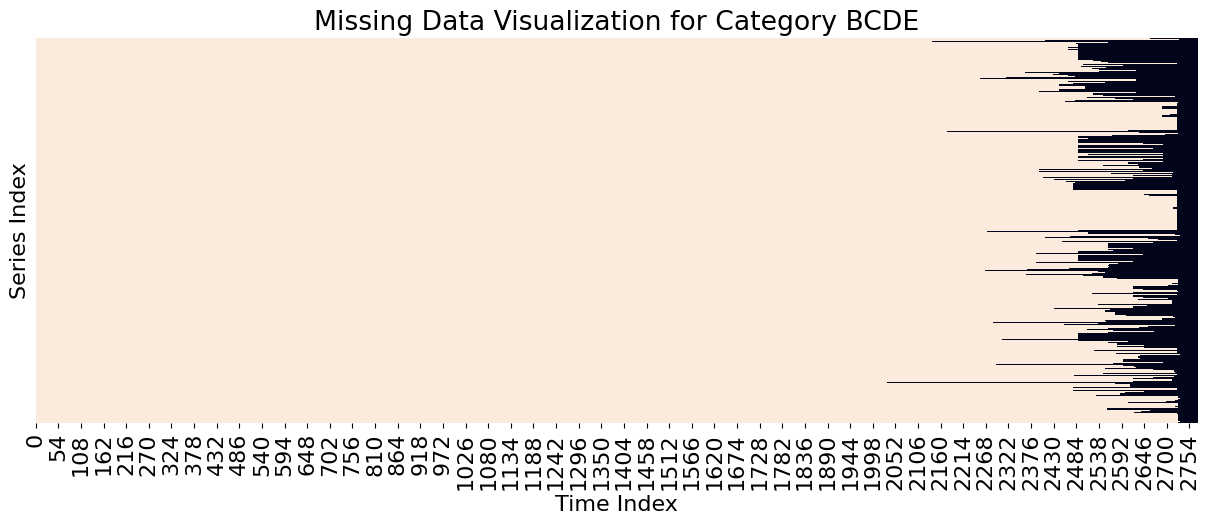

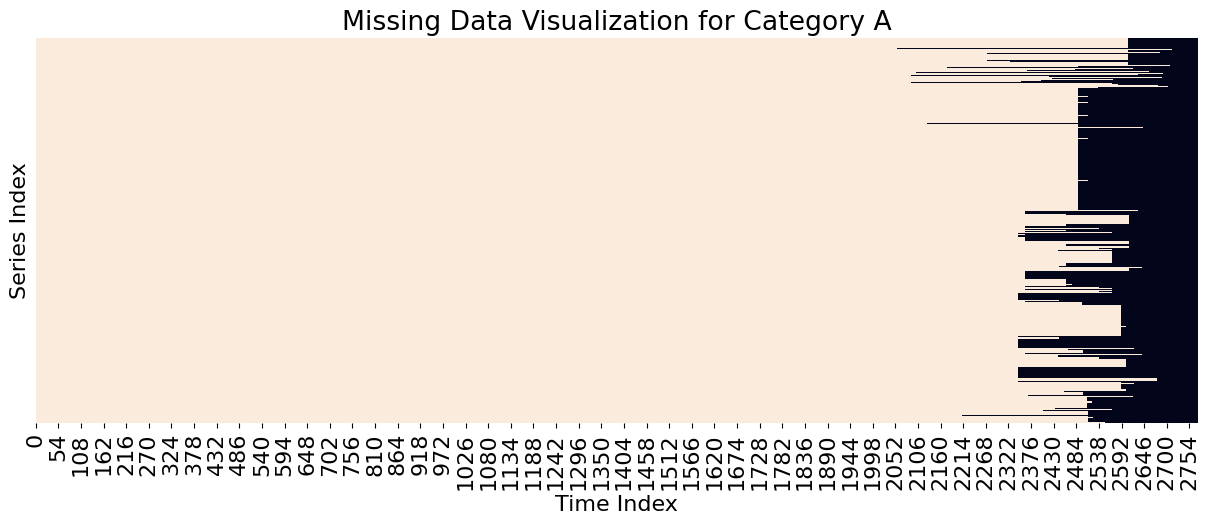

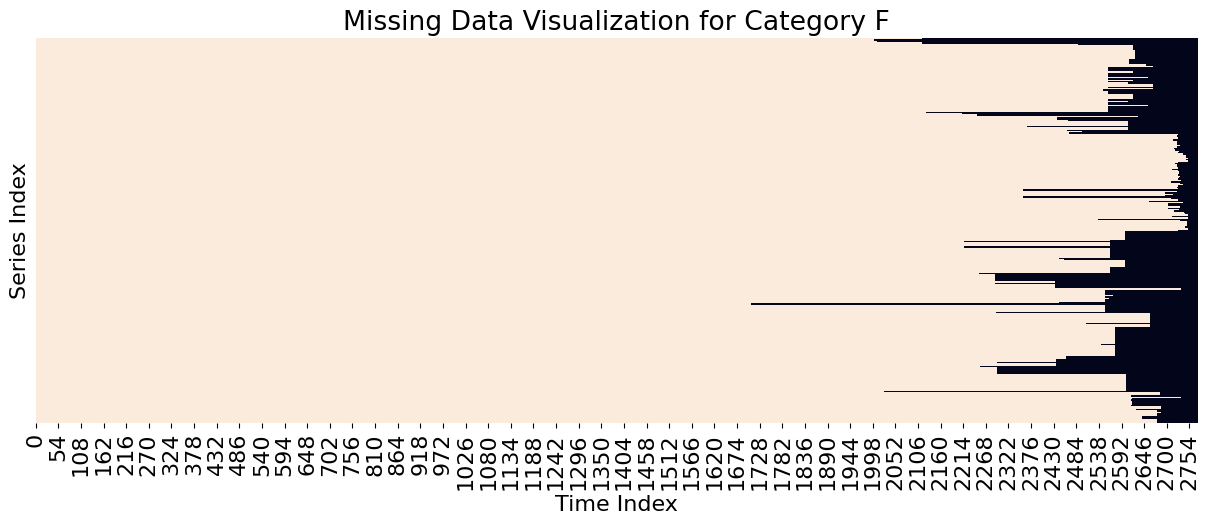

In [31]:
for category, df in data_by_category.items():
    # Remove the last column containing the class labels to only keep the time series data
    df_time_series = df.iloc[:, :-1]

    # Visualize missing data
    plt.figure(figsize=(15, 5))
    sns.heatmap(df_time_series.isna(), cbar=False, yticklabels=False)
    plt.title(f'Missing Data Visualization for Category {category}')
    plt.xlabel('Time Index')
    plt.ylabel('Series Index')
    plt.show()

In [32]:
descriptive_stats_df = pd.DataFrame()

a_values = pd.Series(A.values.ravel()).dropna()
a_description = a_values.describe()
a_description["Category"] = "A"

bcde_values = pd.Series(BCDE.values.ravel()).dropna()
bcde_description = bcde_values.describe()
bcde_description["Category"] = "BCDE"

f_values = pd.Series(F.values.ravel()).dropna()
f_description = f_values.describe()
f_description["Category"] = "F"

descriptive_stats_df = pd.concat([a_description, bcde_description, f_description], axis = 1)
descriptive_stats_df = descriptive_stats_df.transpose()

In [33]:
descriptive_stats_df = descriptive_stats_df.rename(index={0: 'A'})
descriptive_stats_df = descriptive_stats_df.rename(index={1: 'BCDE'})
descriptive_stats_df = descriptive_stats_df.rename(index={2: 'F'})

In [34]:
descriptive_stats_df

,count,mean,std,min,25%,50%,75%,max,Category
A,1593417.0,0.465686,0.257577,0.0,0.250759,0.461422,0.673001,1.0,A
BCDE,7871026.0,0.417002,0.271282,0.0,0.180505,0.390805,0.632839,1.0,BCDE
F,53968.0,0.405106,0.283121,0.0,0.157895,0.363929,0.641363,1.0,F


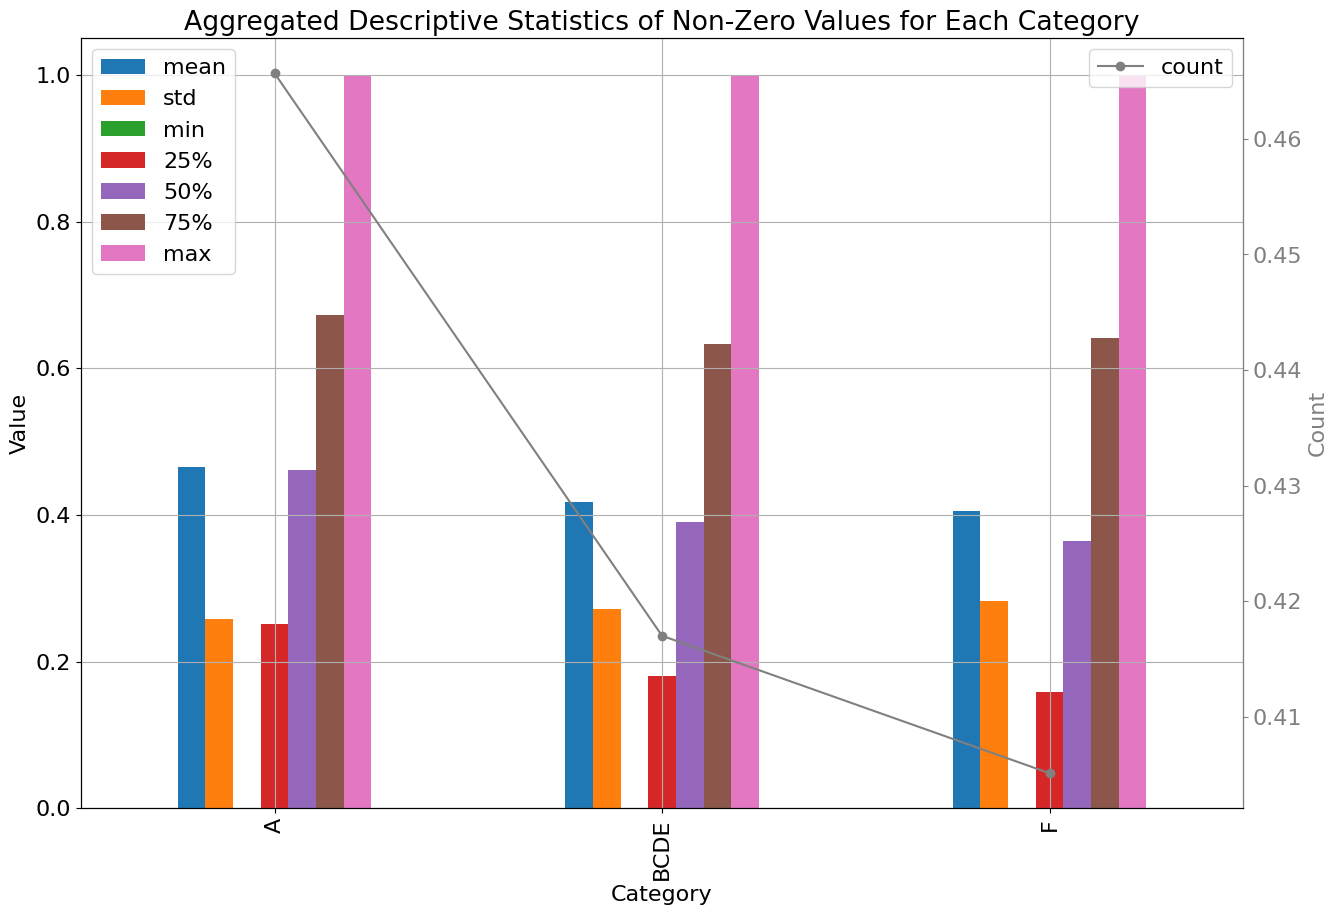

In [35]:
fig, ax1 = plt.subplots(figsize=(15, 10))

descriptive_stats_no_count = descriptive_stats_df.iloc[:,1:]
descriptive_stats_no_count.plot(kind='bar', ax=ax1)


# Create a secondary y-axis for the 'count' statistic
ax2 = ax1.twinx()
ax2.plot(descriptive_stats_df.iloc[:,1], color='gray', marker='o')

# Set the title and labels
ax1.set_title('Aggregated Descriptive Statistics of Non-Zero Values for Each Category')
ax1.set_xlabel('Category')
ax1.set_ylabel('Value')
ax2.set_ylabel('Count', color='gray')

# Set the legend for the primary y-axis
ax1.legend(loc='upper left')

# Set the legend for the secondary y-axis
ax2.legend(['count'], loc='upper right')

# Change the color of the count line to gray
ax2.spines['right'].set_color('gray')
ax2.yaxis.label.set_color('gray')
ax2.tick_params(axis='y', colors='gray')

# Show the grid and the plot
ax1.grid(True)
plt.xticks(rotation=0)
plt.show()

## Expanding the Dataset

In order to enrich the F dataframe, which only contains 277 time series with an average length of 194, we opted for an approach that would allow us to extend them, allowing us to create more sequences for training.

The approach involves using the auto_arima method from the pmdarima library, which finds the optimal parameters for an ARIMA model fitting the time series. We use this method on each of our time series, obtaining optimal parameters. We then test these parameters and calculate the MSE on the prediction of 20 time instances. If the MSE is satisfactory, we use the ARIMA model to add time instances to our time series.

We do this both forward and backward, allowing us to significantly expand a number of time series.

In [36]:
pip install pmdarima

  Obtaining dependency information for pmdarima from https://files.pythonhosted.org/packages/ec/2b/e7d18360d56396b62781ba4616527af49244d4bed51f0780646fa3953cc8/pmdarima-2.0.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 22.0 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [37]:
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA

In [38]:
import warnings
warnings.filterwarnings("ignore")

In [39]:
print("Average length of Time Series before expansion: {}".format(vdf_F["Interval"].mean()))

Average length of Time Series before expansion: 194.8303249097473


## Expanding Backward

In [40]:
steps = 20
counter = 0
greater_than_160 = 0
iterator = 0

for i in range(0, F.shape[0]):
    iterator = iterator + 1
    print("Series {}".format(iterator))
    interval = vdf_F.iloc[i]["Interval"]
    if interval > 160:
        greater_than_160 = greater_than_160 + 1
        
        start, end = vdf_F.iloc[i]["Start"], vdf_F.iloc[i]["End"]
        series = F.iloc[i,start:end]
        series_inv = np.array(np.flip(series))
        x = series_inv[:interval-steps]
        y = series_inv[interval-steps:interval]

        model = pm.auto_arima(series_inv, suppress_warnings=True, seasonal=False,
                      stepwise=True, max_p=5, max_q=5)

        model = ARIMA(x, order=(model.order[0], model.order[1], model.order[2]))
        results = model.fit()

        forecast = results.get_forecast(steps=steps)
        y_pred = forecast.predicted_mean
        mse_new = mse(y, y_pred)
        
        if mse_new < 0.001:
            print("MSE for Time Series {} is {}".format(iterator, mse_new))
            model = ARIMA(series_inv, order=(model.order[0], model.order[1], model.order[2]))
            results = model.fit()
            forecast = results.get_forecast(steps=steps)
            y_pred = forecast.predicted_mean
            y_pred = np.flip(y_pred)
            F.iloc[i, start-steps:start] = y_pred
            vdf_F.iloc[i,0] = vdf_F.iloc[i,0] - steps
                
        del model
        
print("Out of {} time series, {} have mse < 0.001".format(greater_than_160, counter))

Series 1
MSE for Time Series 1 is 5.9254247663544526e-08
Series 2
MSE for Time Series 2 is 1.3174694122165826e-06
Series 3
MSE for Time Series 3 is 1.1046013710187817e-06
Series 4
MSE for Time Series 4 is 9.857073241256675e-07
Series 5
MSE for Time Series 5 is 0.0006052776825271836
Series 6
Series 7
Series 8
Series 9
Series 10
Series 11
Series 12
Series 13
Series 14
Series 15
Series 16
Series 17
Series 18
Series 19
Series 20
Series 21
Series 22
Series 23
MSE for Time Series 23 is 5.511122133355377e-06
Series 24
Series 25
Series 26
MSE for Time Series 26 is 2.7423851420858802e-05
Series 27
Series 28
Series 29
Series 30
Series 31
Series 32
MSE for Time Series 32 is 0.0005447374252507879
Series 33
Series 34
Series 35
Series 36
MSE for Time Series 36 is 0.0004671206946346808
Series 37
Series 38
MSE for Time Series 38 is 0.0006587224111037284
Series 39
Series 40
Series 41
Series 42
Series 43
Series 44
Series 45
MSE for Time Series 45 is 0.0007842076798269334
Series 46
Series 47
Series 48
Se

In [41]:
vdf_F["Interval"] = vdf_F["End"] - vdf_F["Start"]

In [42]:
print("Average length of Time Series after backward expansion: {}".format(vdf_F["Interval"].mean()))

Average length of Time Series after backward expansion: 197.64620938628158


## Expanding Forward

In [43]:
steps = 20
counter = 0
greater_than_160 = 0
iterator = 0

for i in range(F.shape[1], F.shape[1]+steps):
    F[str(i)] = np.nan

for i in range(0, F.shape[0]):
    iterator = iterator + 1
    print("Series {}".format(iterator))
    interval = vdf_F.iloc[i]["Interval"]
    if interval > 160:
        greater_than_160 = greater_than_160 + 1
        start, end = vdf_F.iloc[i]["Start"], vdf_F.iloc[i]["End"]
        series = F.iloc[i,start:end]
        x = series[:interval-steps]
        y = series[interval-steps:interval]

        model = pm.auto_arima(series, suppress_warnings=True, seasonal=False,
                      stepwise=True, max_p=5, max_q=5)

        model = ARIMA(x, order=(model.order[0], model.order[1], model.order[2]))
        results = model.fit()

        forecast = results.get_forecast(steps=steps)
        y_pred = forecast.predicted_mean
        mse_new = mse(y, y_pred)
        
        if mse_new < 0.001:
            print("MSE for Time Series {} is {}".format(iterator, mse_new))
            model = ARIMA(series, order=(model.order[0], model.order[1], model.order[2]))
            results = model.fit()
            forecast = results.get_forecast(steps=steps)
            y_pred = forecast.predicted_mean
            F.iloc[i, end:end+steps] = y_pred
            vdf_F.iloc[i,1] = vdf_F.iloc[i,1] + steps
                
        del model
        
print("Out of {} time series, {} have mse < 0.001".format(greater_than_160, counter))

Series 1
Series 2
Series 3
Series 4
MSE for Time Series 4 is 0.0002955746380424985
Series 5
Series 6
Series 7
Series 8
Series 9
Series 10
Series 11
Series 12
Series 13
Series 14
Series 15
Series 16
Series 17
Series 18
Series 19
Series 20
Series 21
Series 22
Series 23
Series 24
MSE for Time Series 24 is 0.0002760297943445047
Series 25
Series 26
Series 27
Series 28
Series 29
Series 30
Series 31
Series 32
MSE for Time Series 32 is 0.00024495587498640314
Series 33
Series 34
Series 35
Series 36
Series 37
Series 38
Series 39
MSE for Time Series 39 is 0.0002133451841855464
Series 40
MSE for Time Series 40 is 0.0008599630738126293
Series 41
Series 42
Series 43
Series 44
Series 45
MSE for Time Series 45 is 0.00029745808545159644
Series 46
Series 47
Series 48
Series 49
Series 50
Series 51
Series 52
Series 53
Series 54
Series 55
Series 56
Series 57
Series 58
Series 59
Series 60
Series 61
Series 62
Series 63
Series 64
Series 65
Series 66
Series 67
MSE for Time Series 67 is 0.0008932502387479068
Se

In [44]:
vdf_F["Interval"] = vdf_F["End"] - vdf_F["Start"]

In [45]:
print("Average length of Time Series after backward expansion: {}".format(vdf_F["Interval"].mean()))

Average length of Time Series after backward expansion: 199.30685920577616


## Preparing the Sequences and Splitting the Data

In [46]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, BatchNormalization

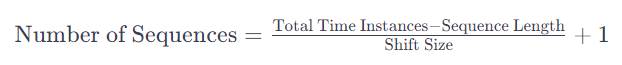

When building our sequences, we exploit the data available in our vdf dataframes, which tells us where each time series starts and ends. We therefore iterate through the rows of our A, BCDE and F dataset and for each time series belonging to these categories we build the sequences which will be used for training.

In [47]:
def build_sequences(df, vdf):
    time_steps = 200
    future_steps = 18
    X, y = [], []
    for i in range(df.shape[0]):
        index = df.index[i]
        start = vdf.loc[index]["Start"]
        end = vdf.loc[index]["End"]
        interval = vdf.loc[index]["Interval"]
        shift = 5 # can change this in order to adjust the window slide
        n_sequences = ((interval - time_steps) // shift) + 1 # number of sequences that will be built for this specific time series
        if end - start > 200:
            for j in range(0, n_sequences):
                if j + start < end - time_steps:
                    series = df.loc[index]
                    X_series = series[start+shift*j:start+time_steps+shift*j]
                    y_series = series[start+shift*j+time_steps:start+j*shift+time_steps+future_steps]
                    if y_series.size == future_steps:
                        if np.isnan(X_series).sum() == 0:
                            if np.isnan(y_series).sum() == 0:
                                y.append(y_series.values)
                                X.append(X_series.values)

    # Convert the lists to numpy arrays
    X = np.array(X)
    y = np.array(y)

    # Now y should be of the correct shape, but let's ensure by reshaping if necessary
    y = y.reshape(-1, future_steps)
    
    return X, y

In [48]:
X_A, y_A = build_sequences(A, vdf_A)
X_BCDE, y_BCDE = build_sequences(BCDE, vdf_BCDE)
X_F, y_F = build_sequences(F, vdf_F)

# we expand the dimensions of the various arrays to fit the LSTM model, in which 1 is the n° of features
X_A = np.expand_dims(X_A, axis=2)
X_BCDE = np.expand_dims(X_BCDE, axis=2)
X_F = np.expand_dims(X_F, axis=2)

# now we split the data
X_trA, X_tsA, y_trA, y_tsA = train_test_split(X_A, y_A, test_size=0.2, shuffle=False)
X_trBCDE, X_tsBCDE, y_trBCDE, y_tsBCDE = train_test_split(X_BCDE, y_BCDE, test_size=0.2, shuffle=False)
X_trF, X_tsF, y_trF, y_tsF = train_test_split(X_F, y_F, test_size=0.2, shuffle=False)

In [49]:
print("X_A Shape: {} X_BCDE Shape: {} X_F Shape: {}".format(X_A.shape, X_BCDE.shape, X_F.shape))
print("X_trA Shape: {} X_trBCDE Shape: {} X_trF Shape: {}".format(X_trA.shape, X_trBCDE.shape, X_trF.shape))
print("X_tsA Shape: {} X_tsBCDE Shape: {} X_tsF Shape: {}".format(X_tsA.shape, X_tsBCDE.shape, X_tsF.shape))
print("y_trA Shape: {} y_trBCDE Shape: {} y_trF Shape: {}".format(y_trA.shape, y_trBCDE.shape, y_trF.shape))
print("y_tsA Shape: {} y_tsBCDE Shape: {} y_tsF Shape: {}".format(y_tsA.shape, y_tsBCDE.shape, y_tsF.shape))

X_A Shape: (90401, 200, 1) X_BCDE Shape: (347814, 200, 1) X_F Shape: (2679, 200, 1)
X_trA Shape: (72320, 200, 1) X_trBCDE Shape: (278251, 200, 1) X_trF Shape: (2143, 200, 1)
X_tsA Shape: (18081, 200, 1) X_tsBCDE Shape: (69563, 200, 1) X_tsF Shape: (536, 200, 1)
y_trA Shape: (72320, 18) y_trBCDE Shape: (278251, 18) y_trF Shape: (2143, 18)
y_tsA Shape: (18081, 18) y_tsBCDE Shape: (69563, 18) y_tsF Shape: (536, 18)


# Models

In [50]:
time_steps = 200
future_steps = 18

## Category A

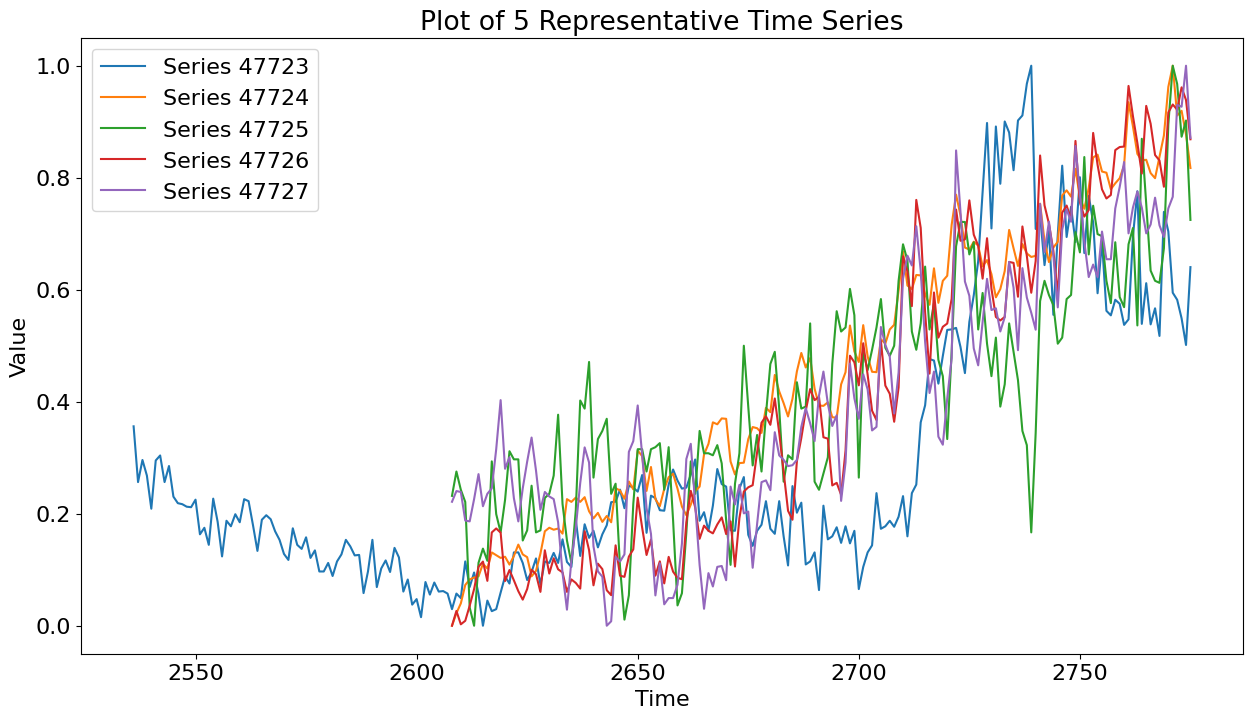

In [51]:
plot_graphs(A,5)

In [52]:
from keras.layers import GRU, Dropout, LayerNormalization, Conv1D

In [53]:
model_A = Sequential()
model_A.add(GRU(150, return_sequences=True, input_shape=(time_steps, 1)))
model_A.add(Dropout(0.2)) 
model_A.add(GRU(75, return_sequences=False))
model_A.add(Dense(future_steps))

In [54]:
# Compile the model
model_A.compile(optimizer='adam', loss='mean_squared_error')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 200, 150)          68850     
                                                                 
 dropout (Dropout)           (None, 200, 150)          0         
                                                                 
 gru_1 (GRU)                 (None, 75)                51075     
                                                                 
 dense (Dense)               (None, 18)                1368      
                                                                 
Total params: 121293 (473.80 KB)
Trainable params: 121293 (473.80 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


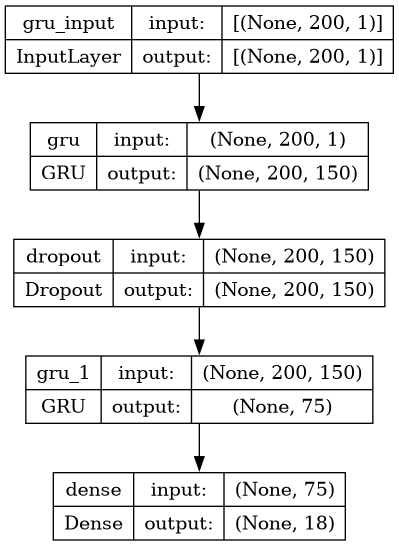

In [55]:
model_A.summary()
tfk.utils.plot_model(model_A, expand_nested=True, show_shapes=True)

In [56]:
epochs = 100
batch_size = 64

In [59]:
history_A = model_A.fit(
    x = X_trA,
    y = y_trA,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=(X_tsA, y_tsA),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/100
1130/1130 [==============================] - 29s 19ms/step - loss: 0.0135 - val_loss: 0.0125 - lr: 0.0010
Epoch 2/100
1130/1130 [==============================] - 20s 18ms/step - loss: 0.0101 - val_loss: 0.0117 - lr: 0.0010
Epoch 3/100
1130/1130 [==============================] - 20s 18ms/step - loss: 0.0097 - val_loss: 0.0114 - lr: 0.0010
Epoch 4/100
1130/1130 [==============================] - 21s 18ms/step - loss: 0.0092 - val_loss: 0.0113 - lr: 0.0010
Epoch 5/100
1130/1130 [==============================] - 21s 19ms/step - loss: 0.0087 - val_loss: 0.0109 - lr: 0.0010
Epoch 6/100
1130/1130 [==============================] - 21s 19ms/step - loss: 0.0086 - val_loss: 0.0112 - lr: 0.0010
Epoch 7/100
1130/1130 [==============================] - 21s 19ms/step - loss: 0.0084 - val_loss: 0.0106 - lr: 0.0010
Epoch 8/100
1130/1130 [==============================] - 21s 19ms/step - loss: 0.0083 - val_loss: 0.0105 - lr: 0.0010
Epoch 9/100
1130/1130 [==============================] -

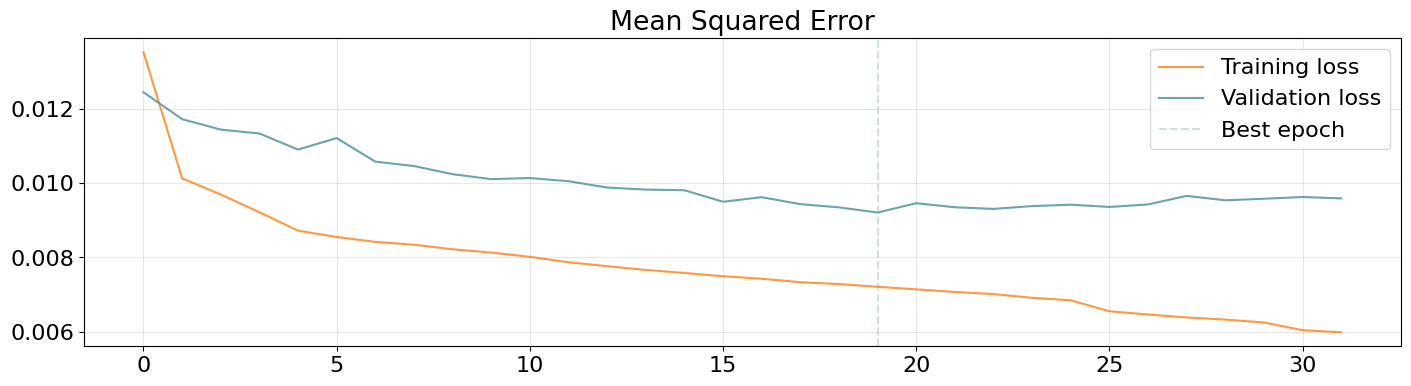

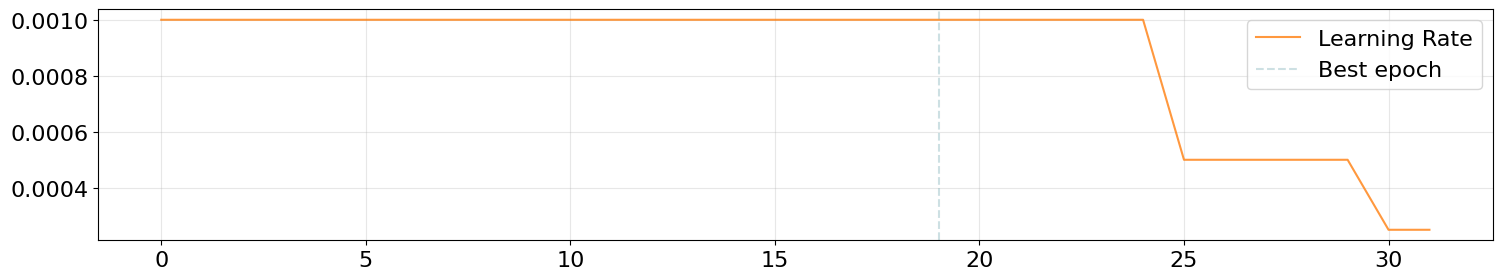

In [60]:
plot_epochs(history_A)

# Category BCDE

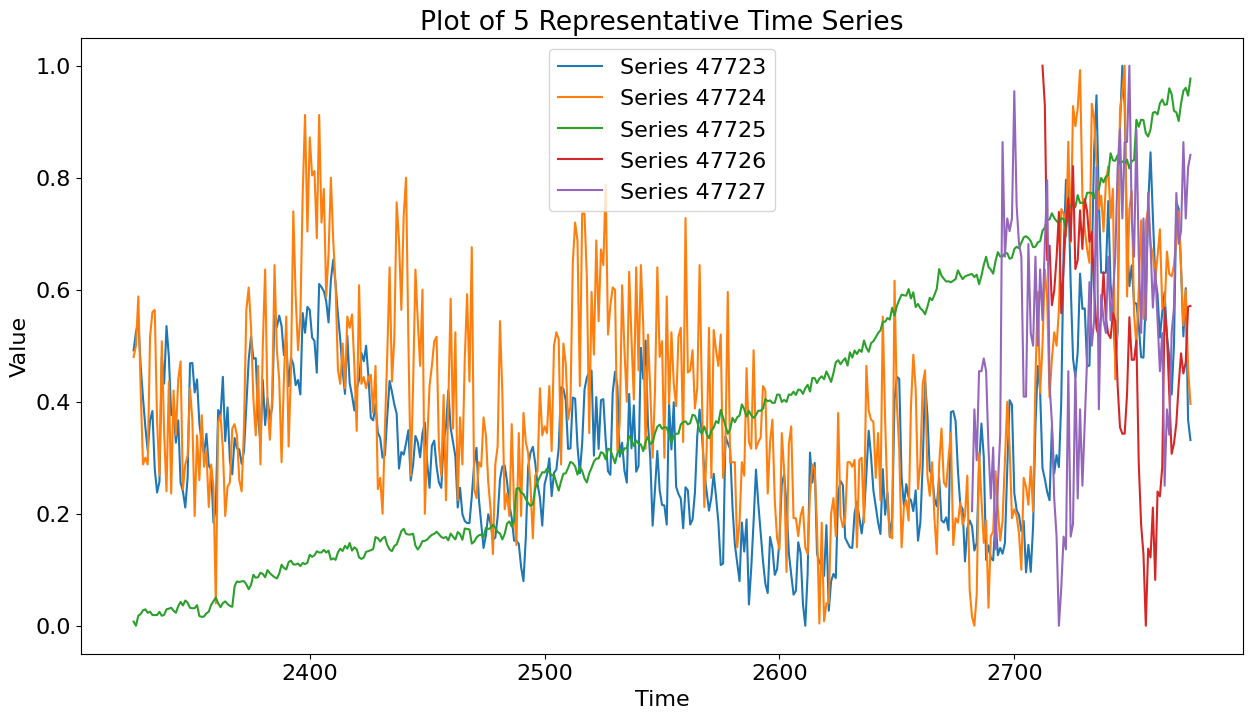

In [61]:
plot_graphs(BCDE, 5)

In [62]:
model_BCDE = Sequential()
model_BCDE.add(GRU(150, return_sequences=True, input_shape=(time_steps, 1)))
model_BCDE.add(Dropout(0.2)) 
model_BCDE.add(GRU(75, return_sequences=False))
model_BCDE.add(Dense(future_steps))

In [63]:
# Compile the model
model_BCDE.compile(optimizer='adam', loss='mean_squared_error')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 200, 150)          68850     
                                                                 
 dropout_1 (Dropout)         (None, 200, 150)          0         
                                                                 
 gru_3 (GRU)                 (None, 75)                51075     
                                                                 
 dense_1 (Dense)             (None, 18)                1368      
                                                                 
Total params: 121293 (473.80 KB)
Trainable params: 121293 (473.80 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


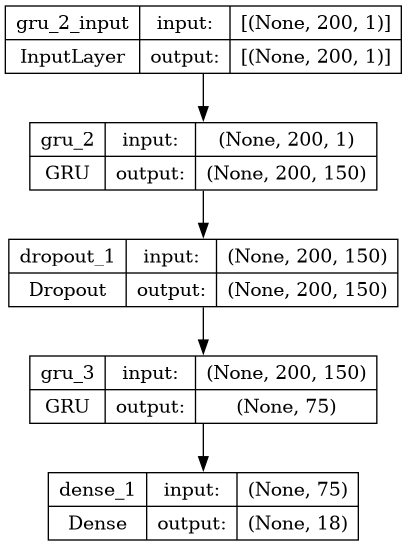

In [64]:
model_BCDE.summary()
tfk.utils.plot_model(model_BCDE, expand_nested=True, show_shapes=True)

In [65]:
# Train the model
history_BCDE = model_BCDE.fit(
    x = X_trBCDE,
    y = y_trBCDE,
    batch_size = 128,
    epochs = epochs,
    validation_data = (X_tsBCDE, y_tsBCDE),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.1, min_lr=1e-5)
    ]
).history

Epoch 1/100
2174/2174 [==============================] - 61s 26ms/step - loss: 0.0138 - val_loss: 0.0117 - lr: 0.0010
Epoch 2/100
2174/2174 [==============================] - 56s 26ms/step - loss: 0.0106 - val_loss: 0.0112 - lr: 0.0010
Epoch 3/100
2174/2174 [==============================] - 56s 26ms/step - loss: 0.0097 - val_loss: 0.0110 - lr: 0.0010
Epoch 4/100
2174/2174 [==============================] - 56s 26ms/step - loss: 0.0092 - val_loss: 0.0105 - lr: 0.0010
Epoch 5/100
2174/2174 [==============================] - 56s 26ms/step - loss: 0.0088 - val_loss: 0.0102 - lr: 0.0010
Epoch 6/100
2174/2174 [==============================] - 56s 26ms/step - loss: 0.0086 - val_loss: 0.0101 - lr: 0.0010
Epoch 7/100
2174/2174 [==============================] - 56s 26ms/step - loss: 0.0084 - val_loss: 0.0098 - lr: 0.0010
Epoch 8/100
2174/2174 [==============================] - 56s 26ms/step - loss: 0.0083 - val_loss: 0.0098 - lr: 0.0010
Epoch 9/100
2174/2174 [==============================] -

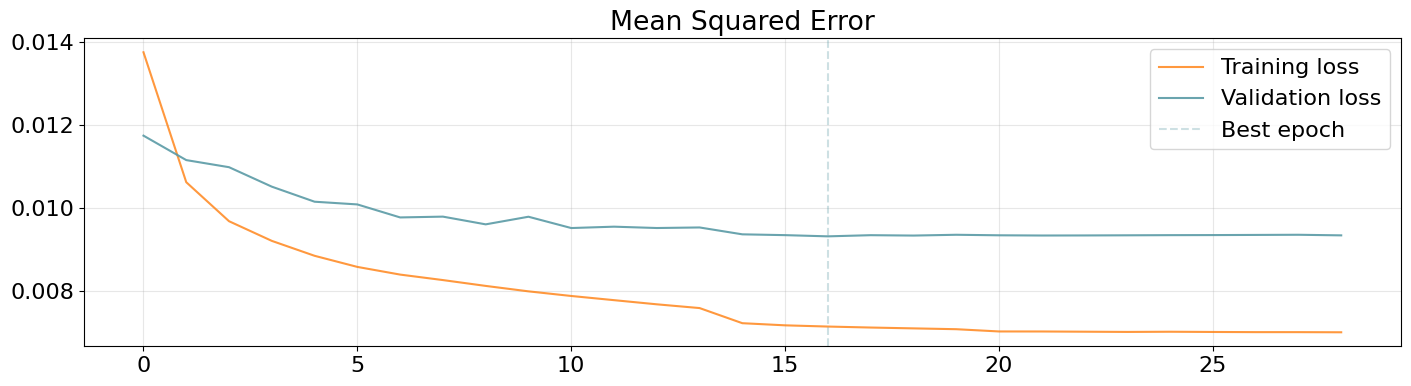

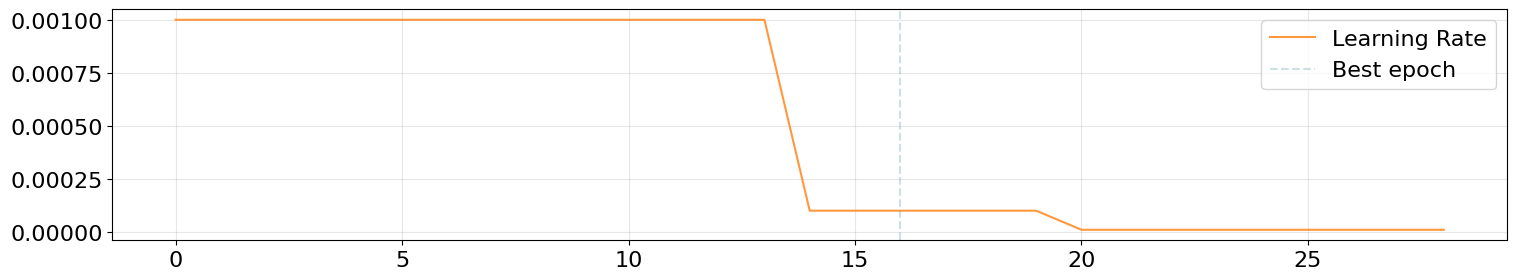

In [66]:
plot_epochs(history_BCDE)

## Category F

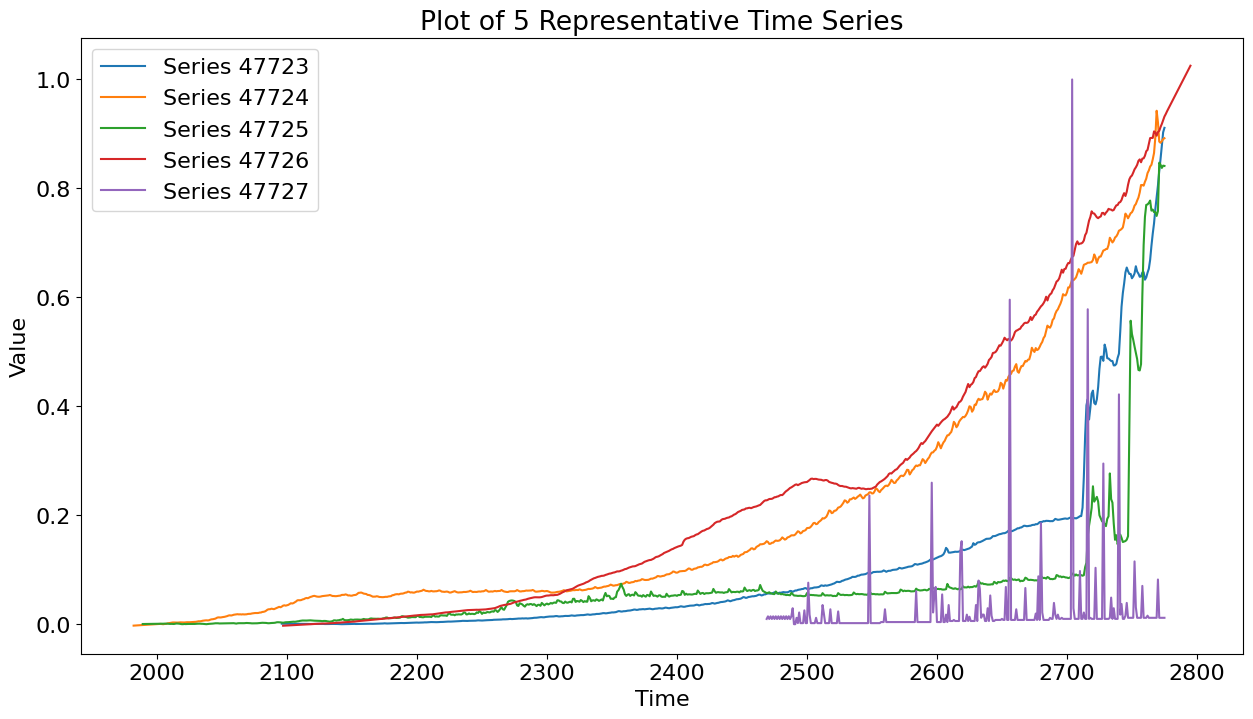

In [67]:
plot_graphs(F, 5)

In [68]:
model_F = Sequential()
model_F.add(GRU(150, return_sequences=True, input_shape=(time_steps, 1)))
model_F.add(Dropout(0.2)) 
model_F.add(GRU(75, return_sequences=False))
model_F.add(Dense(future_steps))

In [69]:
# Compile the model
model_F.compile(optimizer='adam', loss='mean_squared_error')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 200, 150)          68850     
                                                                 
 dropout_2 (Dropout)         (None, 200, 150)          0         
                                                                 
 gru_5 (GRU)                 (None, 75)                51075     
                                                                 
 dense_2 (Dense)             (None, 18)                1368      
                                                                 
Total params: 121293 (473.80 KB)
Trainable params: 121293 (473.80 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


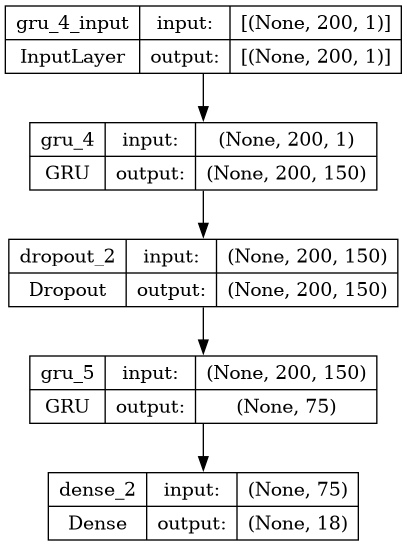

In [70]:
model_F.summary()
tfk.utils.plot_model(model_F, expand_nested=True, show_shapes=True)

In [71]:
# Train the model
history_F = model_F.fit(
    x = X_trF,
    y = y_trF,
    batch_size = 200,
    epochs = epochs,
    validation_data=(X_tsF, y_tsF),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=20, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.1, min_lr=1e-5)
    ]
).history

Epoch 1/100
11/11 [==============================] - 4s 110ms/step - loss: 0.1312 - val_loss: 0.0496 - lr: 0.0010
Epoch 2/100
11/11 [==============================] - 0s 35ms/step - loss: 0.0269 - val_loss: 0.0120 - lr: 0.0010
Epoch 3/100
11/11 [==============================] - 0s 35ms/step - loss: 0.0138 - val_loss: 0.0091 - lr: 0.0010
Epoch 4/100
11/11 [==============================] - 0s 35ms/step - loss: 0.0104 - val_loss: 0.0103 - lr: 0.0010
Epoch 5/100
11/11 [==============================] - 0s 36ms/step - loss: 0.0097 - val_loss: 0.0089 - lr: 0.0010
Epoch 6/100
11/11 [==============================] - 0s 35ms/step - loss: 0.0095 - val_loss: 0.0085 - lr: 0.0010
Epoch 7/100
11/11 [==============================] - 0s 35ms/step - loss: 0.0093 - val_loss: 0.0090 - lr: 0.0010
Epoch 8/100
11/11 [==============================] - 0s 35ms/step - loss: 0.0093 - val_loss: 0.0094 - lr: 0.0010
Epoch 9/100
11/11 [==============================] - 0s 36ms/step - loss: 0.0093 - val_loss: 0.

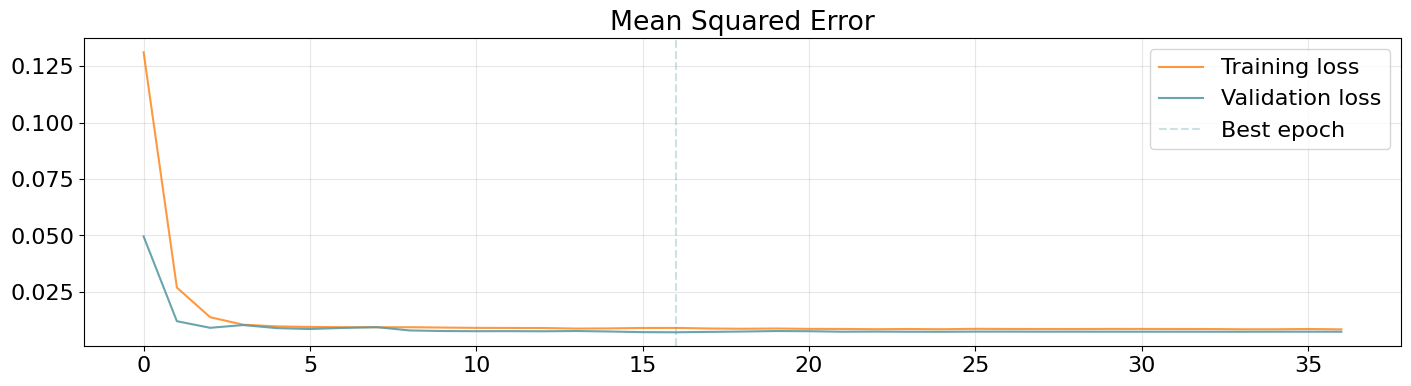

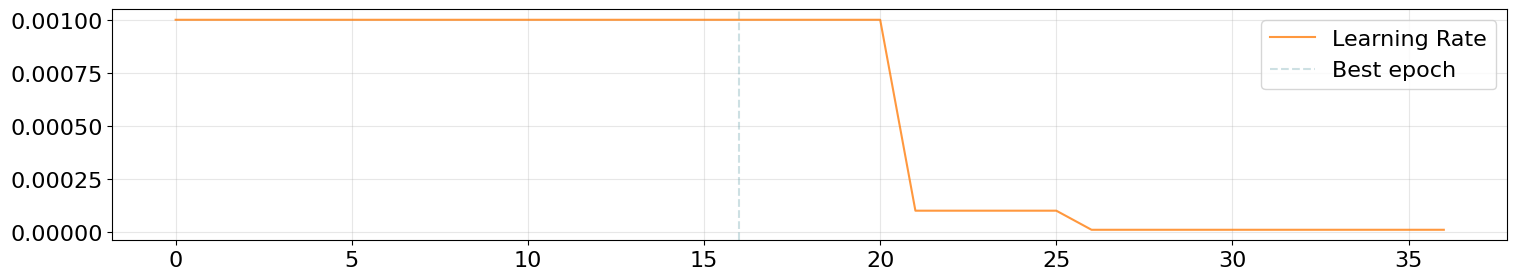

In [72]:
plot_epochs(history_F)

## MSE Summary

In [73]:
from sklearn.metrics import mean_squared_error as mse

In [74]:
model_A.save("model_A")
model_BCDE.save("model_BCDE")
model_F.save("model_F")

In [75]:
y_pred_A = model_A.predict(X_tsA)
errors_A = y_tsA - y_pred_A
mse_A = mse(y_tsA, y_pred_A)

566/566 [==============================] - 4s 6ms/step


In [76]:
y_pred_F = model_F.predict(X_tsF)
errors_F = y_tsF - y_pred_F
mse_F = mse(y_tsF, y_pred_F)

17/17 [==============================] - 1s 6ms/step


In [77]:
y_pred_BCDE = model_BCDE.predict(X_tsBCDE)
errors_BCDE = y_tsBCDE - y_pred_BCDE
mse_BCDE = mse(y_tsBCDE, y_pred_BCDE)

2174/2174 [==============================] - 14s 6ms/step


In [78]:
print("MSE A: {} MSE BCDE: {} MSE F: {}".format(mse_A, mse_BCDE, mse_F))

MSE A: 0.00921105059831969 MSE BCDE: 0.009318826084166737 MSE F: 0.00708878605913243
